https://www.kaggle.com/datasets/batuhanyil/electron-microscopy-particle-segmentation

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#1- Import Libraries
import os
import glob
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
#2- Define Paths:
image_folder = '/content/drive/MyDrive/DataScience/Microscopy_Segmentation/data/images/'
mask_folder = '/content/drive/MyDrive/DataScience/Microscopy_Segmentation/data/segmaps/'

In [9]:
#3- Split Data into training, validation, and testing sets

# Get all image file names
image_filenames_path = sorted(glob.glob(os.path.join(image_folder, "*.png")))
mask_filenames_path = sorted(glob.glob(os.path.join(mask_folder, "*.png")))
assert len(image_filenames_path) == len(mask_filenames_path), "Number of images and masks do not match"
# Remove path
image_filenames = [file.split('/')[-1] for file in image_filenames_path]

val_size=0.2
test_size=0.1

# Split into training and testing sets
train_filenames, test_filenames = train_test_split(image_filenames, test_size=test_size, random_state=42)

# Split training set into training and validation sets
train_filenames, val_filenames = train_test_split(train_filenames, test_size=val_size/(1-test_size), random_state=42)

# Print number of samples in each set
print(f'Total Images: {len(image_filenames)}')
print(f'Total Masks: {len(mask_filenames_path)}')
print(f'Training samples: {len(train_filenames)}')
print(f'Validation samples: {len(val_filenames)}')
print(f'Testing samples: {len(test_filenames)}')

Total Images: 465
Total Masks: 465
Training samples: 325
Validation samples: 93
Testing samples: 47


In [10]:
#4- Define custom Datasets, data augmentation, Data Loaders

class CustomDataset(Dataset):
    def __init__(self, image_filenames, mask_filenames, transforms=None):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        image_name = self.image_filenames[idx]
        img_path = os.path.join(image_folder, self.image_filenames[idx])
        mask_path = os.path.join(mask_folder, self.mask_filenames[idx])

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        if self.transforms is not None:
            seed = np.random.randint(2023)
            
            random.seed(seed)
            torch.manual_seed(seed)
            image = self.transforms(image)
            
            random.seed(seed)
            torch.manual_seed(seed)
            mask = self.transforms(mask)
            
        mask = np.array(mask)
        mask = (mask > 0).astype(np.float32) # astype() -> boolean matrix to float, true = 1.0 and False = 0.0.
        mask = torch.from_numpy(mask)
 
        return image, mask

In [11]:
# Define data augmentation

image_size = (224, 224)

train_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-90,90)),
    transforms.ToTensor()
])

val_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

In [12]:
# Create datasets and data loaders
train_dataset = CustomDataset(train_filenames, train_filenames, train_transforms)
val_dataset = CustomDataset(val_filenames, val_filenames, val_transforms)
test_dataset = CustomDataset(test_filenames, test_filenames, val_transforms)

batch_size = 20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

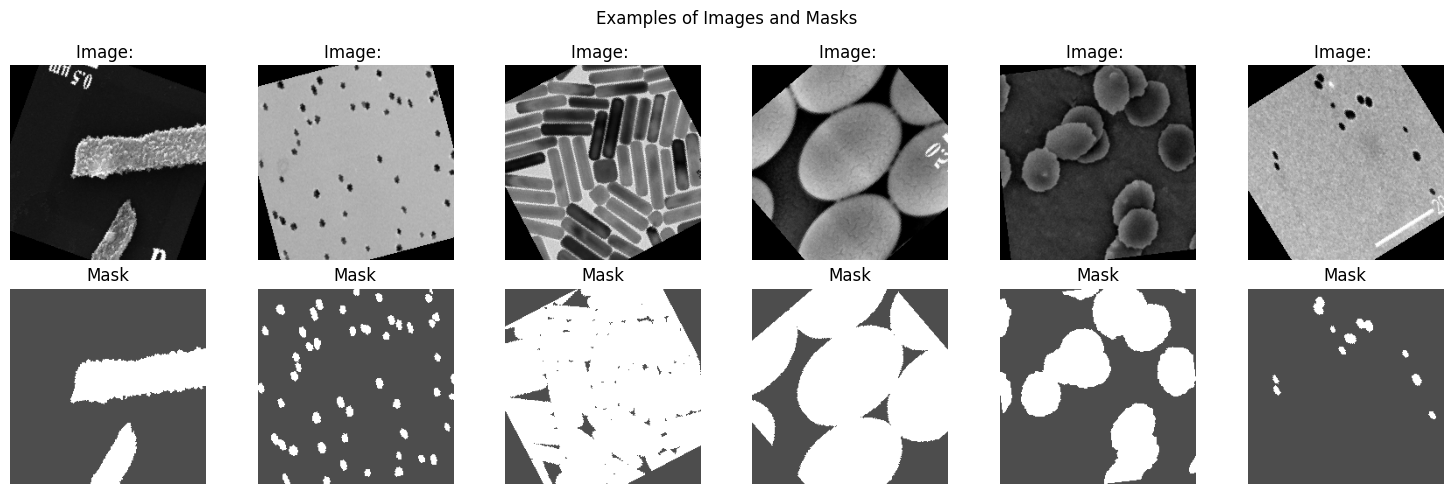

In [13]:
#5- Plot examples of image and mask pairs

images, masks = next(iter(train_loader))

def plot_image_mask_pairs(images, masks, num_pairs=6):
    fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(15, 5))
    fig.suptitle('Examples of Images and Masks')

    for i in range(num_pairs):
        # Plot image
        axs[0, i].imshow(images[i].permute(1,2,0))
        axs[0, i].set_title('Image: ')
        axs[0, i].axis('off')    
        # Plot mask
        axs[1, i].imshow(masks[i].squeeze(dim=0), alpha=0.7, cmap='gray')
        axs[1, i].set_title('Mask')
        axs[1, i].axis('off')

    plt.tight_layout()    
    plt.show()

plot_image_mask_pairs(images, masks)

In [14]:
images[0].type(), masks[0].type()

('torch.FloatTensor', 'torch.FloatTensor')

In [15]:
images[0].size(), masks[0].size()

(torch.Size([3, 224, 224]), torch.Size([1, 224, 224]))

In [16]:
def iou_score(output, target):
    smooth = 1e-6
    intersection = (output * target).sum()
    union = output.sum() + target.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

def jaccard_score(output, target):
    smooth = 1e-6
    intersection = (output * target).sum()
    union = output.sum() + target.sum() - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return jaccard.item()

def f1_score(output, target):
    smooth = 1e-6
    intersection = (output * target).sum()
    f1 = (2 * intersection + smooth) / (output.sum() + target.sum() + smooth)
    return f1.item()

def dice_score(output, target):
    smooth = 1e-6
    intersection = (output * target).sum()
    dice = (2 * intersection + smooth) / (output.sum() + target.sum() + smooth)
    return dice.item()

In [36]:
from torchvision.models import resnet50, ResNet50_Weights
class UNetResNet50(nn.Module):
    def __init__(self, num_classes):
        super(UNetResNet50, self).__init__()
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet_layers = list(self.resnet.children())
        self.conv1 = nn.Sequential(*self.resnet_layers[:3])
        self.layer1 = nn.Sequential(*self.resnet_layers[3:5])
        self.layer2 = self.resnet_layers[5]
        self.layer3 = self.resnet_layers[6]
        self.layer4 = self.resnet_layers[7]
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_up3 = nn.Conv2d(2048, 1024, kernel_size=1)
        self.conv_up2 = nn.Conv2d(1024, 512, kernel_size=1)
        self.conv_up1 = nn.Conv2d(512, 256, kernel_size=1)
        self.conv_up0 = nn.Conv2d(256, 64, kernel_size=1)
        self.conv_final = nn.Conv2d(64, num_classes, kernel_size=1)

        # Freeze all layers except the last two
        for name, param in self.named_parameters():
            if 'conv_final' in name or 'conv_up0' in name or 'conv_up1' in name or 'conv_up2' in name or 'conv_up3' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
         
        # Print all layers
        #for name, module in self.named_modules():
            #print(name)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.upsample(x)
        x = self.conv_up3(x)
        x = self.upsample(x)
        x = self.conv_up2(x)
        x = self.upsample(x)
        x = self.conv_up1(x)
        x = self.upsample(x)
        x = self.conv_up0(x)
        x = self.upsample(x)
        x = self.conv_final(x)
        return x
    
model = UNetResNet50(num_classes=1)
model.to(device)

UNetResNet50(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [37]:
#8- Define Loss Function, Optimizer, scheduler and Early Stopping class:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [38]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss)
        elif score < self.best_score + 0.001:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss)
            self.counter = 0

    def save_checkpoint(self, val_loss):      
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss}, 'best_model_UNetResNet50.pth') 
        
# Initialize early stopping class
early_stopping = EarlyStopping(patience=10, verbose=True)

In [39]:
#9a- Define and execute Training Loop and Validation loop

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train() # model.train()
    running_loss = 0.0
    running_iou = 0.0
    running_jaccard = 0
    running_f1 = 0
    running_dice = 0
    for images, masks in tqdm(dataloader, leave=False):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        running_iou += iou_score(outputs, masks) * images.size(0)
        running_jaccard += jaccard_score(outputs, masks) * images.size(0)
        running_f1 += f1_score(outputs, masks) * images.size(0)
        running_dice += dice_score(outputs, masks) * images.size(0)
        #train_iou += iou_score(outputs > 0.5, masks > 0.5).item()
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_iou = running_iou / len(dataloader.dataset)
    epoch_jaccard = running_jaccard / len(dataloader.dataset)
    epoch_f1 = running_f1 / len(dataloader.dataset)
    epoch_dice = running_dice / len(dataloader.dataset)
    #train_iou /= len(train_loader)
    return epoch_loss, epoch_iou, epoch_jaccard, epoch_f1, epoch_dice

In [40]:
#9b- Define and execute Training Loop and Validation loop

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval() # model.eval()
    running_loss = 0.0
    running_iou = 0.0
    running_jaccard = 0
    running_f1 = 0
    running_dice = 0
    with torch.no_grad():
        for images, masks in tqdm(dataloader, leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            running_loss += loss.item() * images.size(0)
            running_iou += iou_score(outputs, masks) * images.size(0)
            running_jaccard += jaccard_score(outputs, masks) * images.size(0)
            running_f1 += f1_score(outputs, masks) * images.size(0)
            running_dice += dice_score(outputs, masks) * images.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_iou = running_iou / len(dataloader.dataset)
    epoch_jaccard = running_jaccard / len(dataloader.dataset)
    epoch_f1 = running_f1 / len(dataloader.dataset)
    epoch_dice = running_dice / len(dataloader.dataset)
    return epoch_loss, epoch_iou, epoch_jaccard, epoch_f1, epoch_dice

In [41]:
#9c- Define and execute Training Loop and Validation loop

def main(train_loader, val_loader, num_epochs = 0):    
   
    train_loss_history, val_loss_history, train_iou_history, val_iou_history = [], [], [], []
    train_jaccard_history, val_jaccard_history, train_f1_history, val_f1_history = [], [], [], []
    train_dice_history, val_dice_history = [], []
    
    for epoch in range(num_epochs):
        train_loss, train_iou, train_jaccard, train_f1, train_dice = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_iou, val_jaccard, val_f1, val_dice = validate_one_epoch(model, val_loader, criterion, device)
        scheduler.step(val_loss)
        early_stopping(val_loss)
        if early_stopping.early_stop:
            break
        
        train_loss_history.append(train_loss)
        train_iou_history.append(train_iou)
        train_jaccard_history.append(train_jaccard)
        train_f1_history.append(train_f1)
        train_dice_history.append(train_dice)
        
        val_loss_history.append(val_loss)
        val_iou_history.append(val_iou)
        val_jaccard_history.append(val_jaccard)
        val_f1_history.append(val_f1)
        val_dice_history.append(val_dice)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, ")
        print(f"Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f}, ")
        print(f"Train Jaccard: {train_jaccard:.4f}, Val Jaccard: {val_jaccard:.4f}, ")
        print(f"Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, ")
        print(f"Train Dice: {train_dice:.4f}, Val Dice: {val_dice:.4f}")
        
        results_dict = {
            'train_loss_history': train_loss_history,
            'val_loss_history': val_loss_history,
            'train_iou_history': train_iou_history,
            'val_iou_history': val_iou_history,
            'train_jaccard_history': train_jaccard_history,
            'val_jaccard_history': val_jaccard_history,
            'train_f1_history': train_f1_history,
            'val_f1_history': val_f1_history,
            'train_dice_history': train_dice_history,
            'val_dice_history': val_dice_history}        
    return results_dict

# run def main()
results_dict = main(train_loader, val_loader, num_epochs = 100)


Validation loss decreased (inf --> 0.581378).  Saving model ...
Epoch 1/100
Train Loss: 0.5307, Val Loss: 0.5814, 
Train IoU: -0.5800, Val IoU: 1.1923, 
Train Jaccard: -0.5800, Val Jaccard: 1.1923, 
Train F1: -0.2320, Val F1: 0.5301, 
Train Dice: -0.2320, Val Dice: 0.5301


Validation loss decreased (inf --> 0.529891).  Saving model ...
Epoch 2/100
Train Loss: 0.4617, Val Loss: 0.5299, 
Train IoU: -0.8593, Val IoU: -0.4614, 
Train Jaccard: -0.8593, Val Jaccard: -0.4614, 
Train F1: -5.0158, Val F1: 14.7135, 
Train Dice: -5.0158, Val Dice: 14.7135


EarlyStopping counter: 1 out of 10
Epoch 3/100
Train Loss: 0.4396, Val Loss: 0.5435, 
Train IoU: -0.2810, Val IoU: -7.8159, 
Train Jaccard: -0.2810, Val Jaccard: -7.8159, 
Train F1: 0.8791, Val F1: 2.4911, 
Train Dice: 0.8791, Val Dice: 2.4911


Validation loss decreased (inf --> 0.519373).  Saving model ...
Epoch 4/100
Train Loss: 0.4279, Val Loss: 0.5194, 
Train IoU: -0.3755, Val IoU: -0.6836, 
Train Jaccard: -0.3755, Val Jaccard: -0.6836, 
Train F1: 7.3206, Val F1: -1.4344, 
Train Dice: 7.3206, Val Dice: -1.4344


Validation loss decreased (inf --> 0.494534).  Saving model ...
Epoch 5/100
Train Loss: 0.4200, Val Loss: 0.4945, 
Train IoU: -0.2176, Val IoU: -0.7233, 
Train Jaccard: -0.2176, Val Jaccard: -0.7233, 
Train F1: -0.5944, Val F1: -18.4314, 
Train Dice: -0.5944, Val Dice: -18.4314


Validation loss decreased (inf --> 0.464367).  Saving model ...
Epoch 6/100
Train Loss: 0.4258, Val Loss: 0.4644, 
Train IoU: -0.1735, Val IoU: -0.3921, 
Train Jaccard: -0.1735, Val Jaccard: -0.3921, 
Train F1: -0.4412, Val F1: -1.4146, 
Train Dice: -0.4412, Val Dice: -1.4146


EarlyStopping counter: 1 out of 10
Epoch 7/100
Train Loss: 0.4202, Val Loss: 0.4700, 
Train IoU: -0.2523, Val IoU: -0.3805, 
Train Jaccard: -0.2523, Val Jaccard: -0.3805, 
Train F1: -0.7992, Val F1: -1.3487, 
Train Dice: -0.7992, Val Dice: -1.3487


EarlyStopping counter: 2 out of 10
Epoch 8/100
Train Loss: 0.4073, Val Loss: 0.4635, 
Train IoU: -0.2155, Val IoU: -0.2354, 
Train Jaccard: -0.2155, Val Jaccard: -0.2354, 
Train F1: -0.6030, Val F1: -0.6565, 
Train Dice: -0.6030, Val Dice: -0.6565


EarlyStopping counter: 3 out of 10
Epoch 9/100
Train Loss: 0.4087, Val Loss: 0.4765, 
Train IoU: -0.1736, Val IoU: -0.4736, 
Train Jaccard: -0.1736, Val Jaccard: -0.4736, 
Train F1: -0.4621, Val F1: -2.0220, 
Train Dice: -0.4621, Val Dice: -2.0220


Validation loss decreased (inf --> 0.461729).  Saving model ...
Epoch 10/100
Train Loss: 0.4147, Val Loss: 0.4617, 
Train IoU: -0.3029, Val IoU: -0.0590, 
Train Jaccard: -0.3029, Val Jaccard: -0.0590, 
Train F1: -1.2098, Val F1: -0.1393, 
Train Dice: -1.2098, Val Dice: -0.1393


Validation loss decreased (inf --> 0.458524).  Saving model ...
Epoch 11/100
Train Loss: 0.4123, Val Loss: 0.4585, 
Train IoU: -0.2047, Val IoU: -0.1301, 
Train Jaccard: -0.2047, Val Jaccard: -0.1301, 
Train F1: -0.6229, Val F1: -0.3268, 
Train Dice: -0.6229, Val Dice: -0.3268


EarlyStopping counter: 1 out of 10
Epoch 12/100
Train Loss: 0.4095, Val Loss: 0.4626, 
Train IoU: -0.2198, Val IoU: -0.1682, 
Train Jaccard: -0.2198, Val Jaccard: -0.1682, 
Train F1: -0.6083, Val F1: -0.4330, 
Train Dice: -0.6083, Val Dice: -0.4330


EarlyStopping counter: 2 out of 10
Epoch 13/100
Train Loss: 0.4031, Val Loss: 0.4641, 
Train IoU: -0.2336, Val IoU: -0.3371, 
Train Jaccard: -0.2336, Val Jaccard: -0.3371, 
Train F1: -0.6772, Val F1: -1.1455, 
Train Dice: -0.6772, Val Dice: -1.1455


EarlyStopping counter: 3 out of 10
Epoch 14/100
Train Loss: 0.4127, Val Loss: 0.4713, 
Train IoU: -0.2118, Val IoU: -0.3785, 
Train Jaccard: -0.2118, Val Jaccard: -0.3785, 
Train F1: -0.5798, Val F1: -1.3457, 
Train Dice: -0.5798, Val Dice: -1.3457


EarlyStopping counter: 4 out of 10
Epoch 15/100
Train Loss: 0.4070, Val Loss: 0.4687, 
Train IoU: -0.2064, Val IoU: -0.1323, 
Train Jaccard: -0.2064, Val Jaccard: -0.1323, 
Train F1: -0.5572, Val F1: -0.3337, 
Train Dice: -0.5572, Val Dice: -0.3337


EarlyStopping counter: 5 out of 10
Epoch 16/100
Train Loss: 0.4050, Val Loss: 0.4657, 
Train IoU: -0.2181, Val IoU: -0.1480, 
Train Jaccard: -0.2181, Val Jaccard: -0.1480, 
Train F1: -0.5974, Val F1: -0.3784, 
Train Dice: -0.5974, Val Dice: -0.3784


Epoch 00017: reducing learning rate of group 0 to 1.0000e-04.
EarlyStopping counter: 6 out of 10
Epoch 17/100
Train Loss: 0.4065, Val Loss: 0.4686, 
Train IoU: -0.2015, Val IoU: -0.2156, 
Train Jaccard: -0.2015, Val Jaccard: -0.2156, 
Train F1: -0.5745, Val F1: -0.6201, 
Train Dice: -0.5745, Val Dice: -0.6201


EarlyStopping counter: 7 out of 10
Epoch 18/100
Train Loss: 0.3984, Val Loss: 0.4648, 
Train IoU: -0.2722, Val IoU: -0.1922, 
Train Jaccard: -0.2722, Val Jaccard: -0.1922, 
Train F1: -0.7918, Val F1: -0.5125, 
Train Dice: -0.7918, Val Dice: -0.5125


EarlyStopping counter: 8 out of 10
Epoch 19/100
Train Loss: 0.4007, Val Loss: 0.4661, 
Train IoU: -0.1809, Val IoU: -0.2446, 
Train Jaccard: -0.1809, Val Jaccard: -0.2446, 
Train F1: -0.4502, Val F1: -0.7133, 
Train Dice: -0.4502, Val Dice: -0.7133


EarlyStopping counter: 9 out of 10
Epoch 20/100
Train Loss: 0.3994, Val Loss: 0.4602, 
Train IoU: -0.2441, Val IoU: -0.2010, 
Train Jaccard: -0.2441, Val Jaccard: -0.2010, 
Train F1: -0.6774, Val F1: -0.5384, 
Train Dice: -0.6774, Val Dice: -0.5384


EarlyStopping counter: 10 out of 10


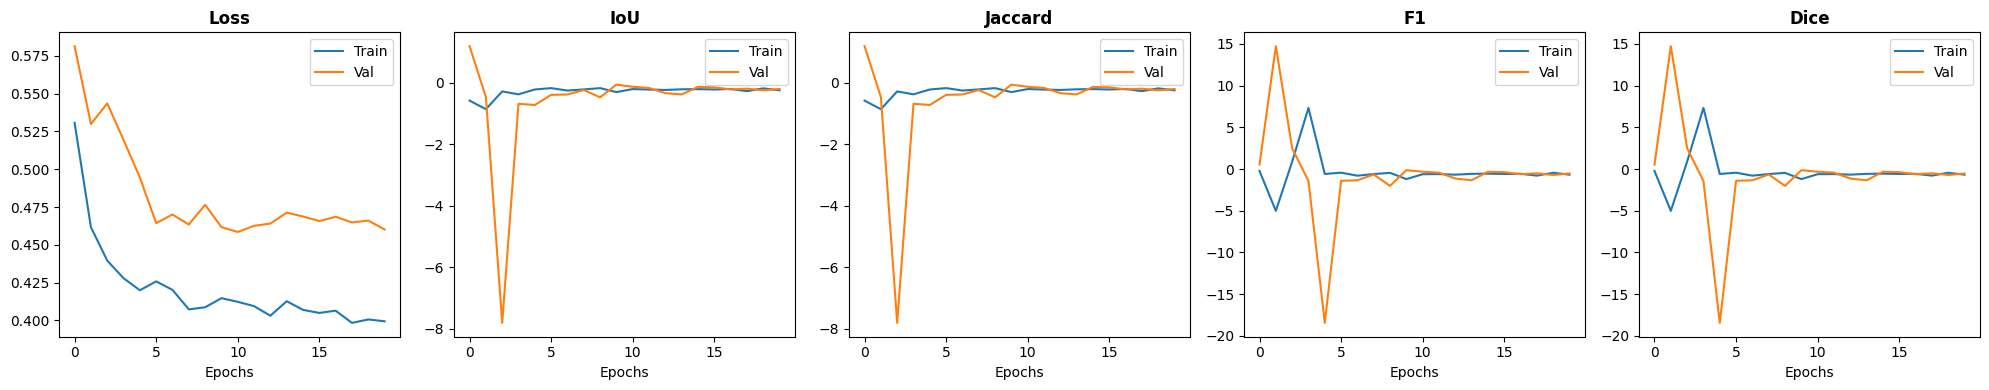

In [42]:
def plot_history(results_dict):
    score_groups = {
        'Loss': ['train_loss_history', 'val_loss_history'],
        'IoU': ['train_iou_history', 'val_iou_history'],
        'Jaccard': ['train_jaccard_history', 'val_jaccard_history'],
        'F1': ['train_f1_history', 'val_f1_history'],
        'Dice': ['train_dice_history', 'val_dice_history']}

    fig, axs = plt.subplots(1, 5, figsize=(20, 4))

    for i, (score_name, score_vars) in enumerate(score_groups.items()):
        axs[i].plot(results_dict[score_vars[0]], label='Train')
        axs[i].plot(results_dict[score_vars[1]], label='Val')
        axs[i].set_title(score_name, fontweight ='bold')
        axs[i].set_xlabel("Epochs")
        axs[i].legend()

    plt.tight_layout()
    plt.show()
    
plot_history(results_dict)

In [43]:
#11- Evaluate model on the test set
def evaluate(model, dataloader, criterion, device):
    model.eval() # model.eval()
    running_loss = 0.0
    running_iou = 0.0
    running_jaccard = 0
    running_f1 = 0
    running_dice = 0
    outputs_test=[]
    with torch.no_grad():
        for images, masks in tqdm(dataloader, leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs_test.append(outputs)
            loss = criterion(outputs, masks)
            
            running_loss += loss.item() * images.size(0)
            running_iou += iou_score(outputs, masks) * images.size(0)
            running_jaccard += jaccard_score(outputs, masks) * images.size(0)
            running_f1 += f1_score(outputs, masks) * images.size(0)
            running_dice += dice_score(outputs, masks) * images.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_iou = running_iou / len(dataloader.dataset)
    epoch_jaccard = running_jaccard / len(dataloader.dataset)
    epoch_f1 = running_f1 / len(dataloader.dataset)
    epoch_dice = running_dice / len(dataloader.dataset)
    
    print(f"Test Loss: {epoch_loss:.4f}, ")
    print(f"Test IoU: {epoch_iou:.4f}, ")
    print(f"Test Jaccard: {epoch_jaccard:.4f}, ")
    print(f"Test F1: {epoch_f1:.4f}, ")
    print(f"Test Dice: {epoch_dice:.4f}, ")
        
    results_dict_test = {
        'Test_Loss': epoch_loss,
        'Test_IoU': epoch_iou,
        'Test_Jaccard': epoch_jaccard,
        'Test_F1': epoch_f1,
        'Test_Dice': epoch_dice}
    
    return results_dict_test

results_dict_test = evaluate(model, test_loader, criterion, device)

Test Loss: 0.4251, 
Test IoU: -0.5696, 
Test Jaccard: -0.5696, 
Test F1: 0.2058, 
Test Dice: 0.2058, 


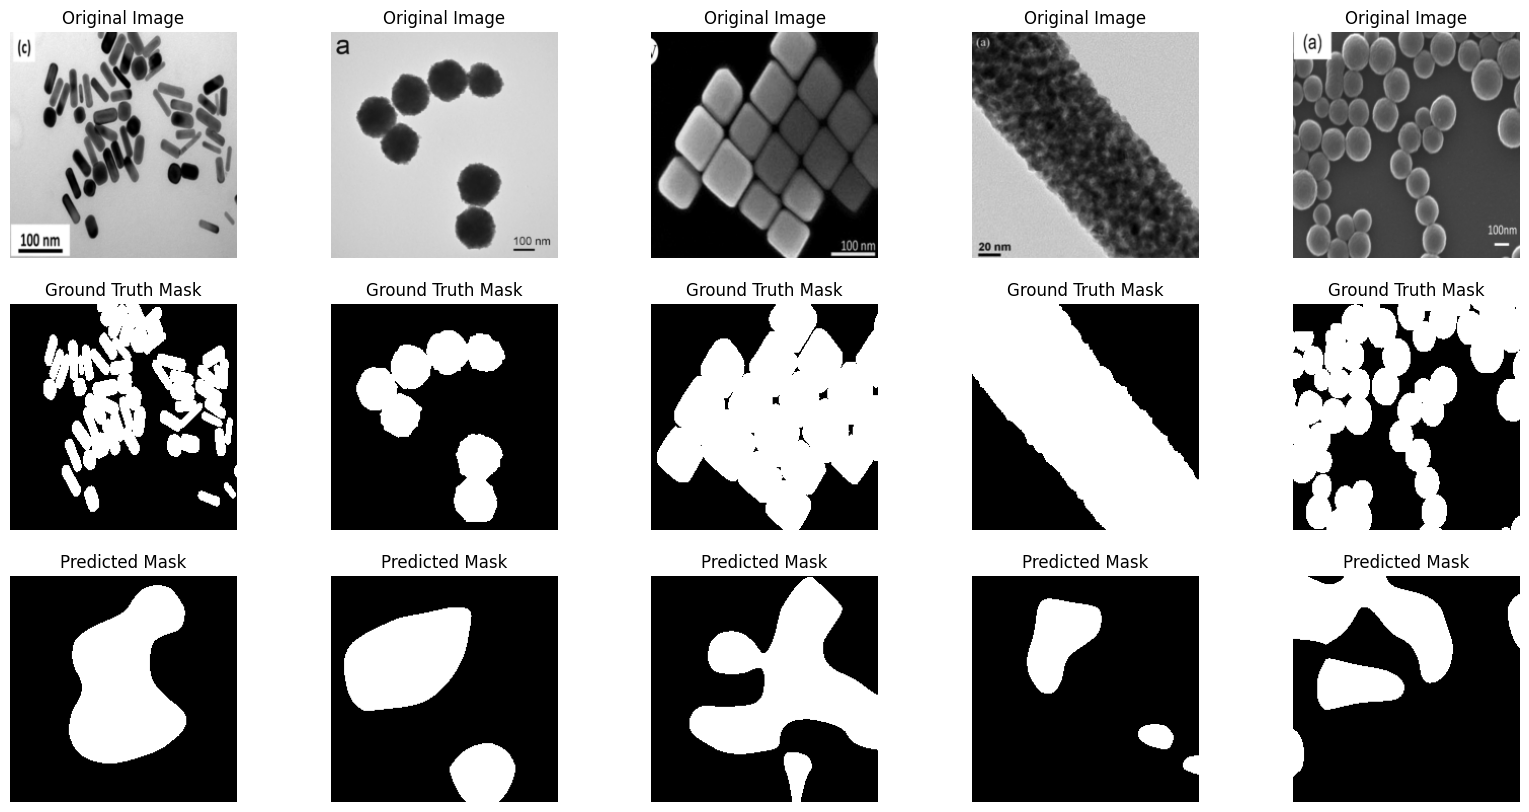

In [47]:
# 12- Plot model evaluated on the test set

# create an instance of the same model architecture
#model = MyModel()
checkpoint = torch.load('best_model_UNetResNet50.pth')
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#val_loss = checkpoint['val_loss']
model.eval()
with torch.no_grad():
    # Get a batch of images and masks from the dataloader
    images, masks = next(iter(test_loader))
    # Move the tensors to the device used for training (CPU or GPU)
    images = images.to(device)
    masks = masks.to(device)
    # Get the predicted masks from the model
    outputs = model(images)

    # Convert the tensors to numpy arrays
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    outputs = outputs.cpu().numpy()
    outputs = (outputs > 0.2).astype('uint8') * 255

    # Plot the first 10 images and their corresponding masks and predicted masks
    fig, ax = plt.subplots(3, 5, figsize=(20, 10))
    for i in range(5):
        # Plot the original image
        ax[0, i].imshow(np.transpose(images[i], (1, 2, 0)))
        ax[0, i].axis('off')
        ax[0, i].set_title('Original Image')

        # Plot the ground truth mask
        ax[1, i].imshow(masks[i].squeeze(), cmap='gray')
        ax[1, i].axis('off')
        ax[1, i].set_title('Ground Truth Mask')

        # Plot the predicted mask
        ax[2, i].imshow(outputs[i].squeeze(), cmap='gray')
        ax[2, i].axis('off')
        ax[2, i].set_title('Predicted Mask')

    plt.show()


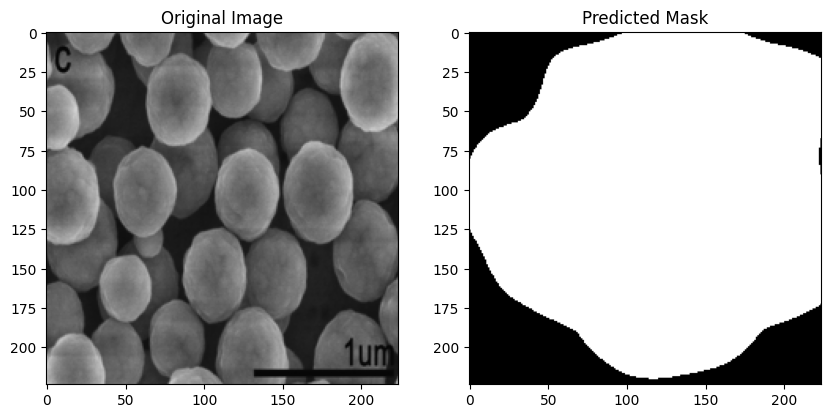

In [48]:
# 13- Use the saved model for inference on new images,
def infer(model, image_path):
    model.eval()
    image_size = (224, 224)
    # Load the image
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    img = transform(img).to(device)
    img=img.unsqueeze(0)

    # Predict the mask
    with torch.no_grad():
        pred_mask = model(img)
    pred_mask = pred_mask > 0.2
    pred_mask = pred_mask.squeeze(0).permute(1, 2, 0).cpu().numpy().astype('uint8') * 255
   
    # Plot the results
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img.squeeze(0).permute(1, 2, 0).cpu().numpy())
    ax[0].set_title('Original Image')
    ax[1].imshow(pred_mask, cmap='gray')
    ax[1].set_title('Predicted Mask')
    plt.show()


all_filenames = os.listdir(image_folder)
img_sample = random.sample(all_filenames, 1)   
# Inference
infer(model, image_folder+img_sample[0])
